# Actor-Critic RL: 2D-Turb-Snapshot Filter

In [1]:
using GeophysicalFlows, JLD2, Interpolations, Statistics

dev = CPU()
const n = 512 # grid resolution 
const L = 2π  # domain length           

##### Load Velocity Field #####
file = jldopen("../../../../Data Generation/2d-turb-data.jld")
u_data = file["vel_x"][:,:,1]
v_data = file["vel_y"][:,:,1]
vort_data = file["vort"][:,:,1]
close(file)

##### Load Filtered Velocity Field #####
file_filt = jldopen("../../../../Data Generation/2d-turb-data-filter-k2.jld")
u_data_filt = file_filt["vel_x"][:,:,1]
v_data_filt = file_filt["vel_y"][:,:,1]
vort_data_filt = file_filt["vort"][:,:,1]
close(file_filt)

##### Interpolations #####
itp_vort = interpolate(vort_data, BSpline(Linear(Periodic())))
itp_u = interpolate(u_data, BSpline(Linear(Periodic())))
itp_v = interpolate(v_data, BSpline(Linear(Periodic())))

itp_vort_filt = interpolate(vort_data_filt, BSpline(Linear(Periodic())))
itp_u_filt = interpolate(u_data_filt, BSpline(Linear(Periodic())))
itp_v_filt = interpolate(v_data_filt, BSpline(Linear(Periodic())))

etp_vort = extrapolate(itp_vort, Periodic())
etp_u = extrapolate(itp_u, Periodic())
etp_v = extrapolate(itp_v, Periodic())

etp_vort_filt = extrapolate(itp_vort_filt, Periodic())
etp_u_filt = extrapolate(itp_u_filt, Periodic())
etp_v_filt = extrapolate(itp_v_filt, Periodic())

vort(x,y) = etp_vort(n*x/L+1, n*y/L+1)
velX(x,y) = etp_u(n*x/L+1, n*y/L+1)
velY(x,y) = etp_v(n*x/L+1, n*y/L+1)

vort_filt(x,y) = etp_vort_filt(n*x/L+1, n*y/L+1)
velX_filt(x,y) = etp_u_filt(n*x/L+1, n*y/L+1)
velY_filt(x,y) = etp_v_filt(n*x/L+1, n*y/L+1)

##### Start, End #####
xA = 1.2
yA = 5.5
rA = 0.2

xB = 5.2
yB = 1.8
rB = 0.2

N_tile = 30 
δ = L/N_tile # grid size for tiling

u0 = maximum(sqrt.(u_data.^2+v_data.^2)) # background maximum velocity
Va = 0.3*u0 # agent's velocity
Δt = δ/(2*u0) # agent's reaction time
Na = 8 # number of actions

n_episodes = 5000 # number of episodes for evaluation
n_train = 100000 # number of episodes for training

T_free = sqrt((xB-xA)^2+(yB-yA)^2)/Va
T_max = 5*T_free

w_reward = 1.0 # weight in the reward function

# generate starting position
function start_point()
    ϕ = 2π*rand()
    r = rA*sqrt(rand())
    return xA+r*cos(ϕ), yA+r*sin(ϕ)
end

# checking that the agent did not hit the border or target
function is_terminal(x,y)
    if (x<=0)||(y<=0)||(x>=L)||(y>=L)
        return true
    elseif sqrt((xB-x)^2+(yB-y)^2)<=rB
        return true
    else
        return false
    end
end 

nothing

In [2]:
# here we integrate the equations of motion over an interval Δt
using OrdinaryDiffEq

function advection!(du, u, p, t)
    x, y = u
    θ = p
    du[1] = dx = velX(x,y) + Va*cos(θ)
    du[2] = dy = velY(x,y) + Va*sin(θ)
end

tspan = (0.0, Δt)

function next_state(x, y, θ)
    prob = ODEProblem(advection!, [x, y], tspan, θ)
    sol = solve(prob, Tsit5(), p = θ, reltol = 1e-12, abstol = 1e-12)
    return sol(Δt)[1], sol(Δt)[2]
end

# less accurate integration to increase training speed
n_steps = 10
dt = Δt/n_steps # integration time-step

function next_state_filt(x, y, θ)
    x_star, y_star = x, y
    
    for i in 1:n_steps
        dx = dt*(velX_filt(x_star, y_star) + Va*cos(θ))
        dy = dt*(velY_filt(x_star, y_star) + Va*sin(θ))
        x_star += dx
        y_star += dy        
    end
    
    return x_star, y_star    
end

nothing

In [3]:
# get the current state (s_x, s_y) based on the current position (x,y) 
function get_tile(x,y)
    return Int(ceil(x/δ)), Int(ceil(y/δ))
end

h = zeros(N_tile, N_tile, Na) # function for policy parametrization h[x-tile, y-tile, action]
w = zeros(N_tile, N_tile) # approximation for state-value function

# the set of possible actions N_a=8 
actions = [-3π/4, -π/2, -π/4, 0, π/4, π/2, 3π/4, π]

# return action according to the current policy
function choose_action(s_x::Int, s_y::Int)
    weights = exp.(h[s_x, s_y, :])
    return actions[findfirst(cumsum(weights) .> rand() * sum(weights))]
end

# return greedy action (used for policy evaluation after training)
function choose_greedy_action(s_x::Int, s_y::Int)
    return actions[argmax(h[s_x,s_y,:])]
end    

# policy, i.e. probabilities for different actions
function policy(s_x::Int, s_y::Int, action::Int)
    return exp(h[s_x, s_y, action])/sum(exp.(h[s_x,s_y,:]))    
end

# initialization of the state-function approximation:
# the further from the end point, the lower the expected return w[i,j]
sx_B, sy_B = get_tile(xB, yB)

for i in 1:N_tile
    for j in 1:N_tile
        w[i,j]= -sqrt((i-sx_B)^2 + (j-sy_B)^2)*δ/Va + w_reward*T_free
    end
end

nothing

### RL Training

In [4]:
# we save total rewards
r_tracks = []

α_w = 0.01 # learning rate for value function
α_h = 0.005 # learning rate for policy

for i in 1:n_train
    r_points = []
    
    # log to monitor training progress
    if i%10000==0
        println("i=",i)
    end
    
    #=
    # adaptive learning rate
    if i==20000
        α_w = α_w/5
        α_h = α_h/5
    end
    =#

    x_now, y_now = start_point()
    step = 0
    
    while (is_terminal(x_now, y_now)==false)&&(step*Δt<T_max)        
        sx_now, sy_now = get_tile(x_now, y_now)
        θ_now = choose_action(sx_now,sy_now)
        action_num = 4+round(Int, 4*θ_now/π)

        x_next, y_next = next_state_filt(x_now, y_now, θ_now)
        step+=1
        
        reward = -Δt + w_reward*(sqrt((xB-x_now)^2+(yB-y_now)^2)/Va - sqrt((xB-x_next)^2+(yB-y_next)^2)/Va)
        
        # checking that the agent did not hit the border
        if (x_next<=0)||(y_next<=0)||(x_next>=L)||(y_next>=L)
            reward=reward-2*T_max
        end
        
        push!(r_points, reward)
        
        # Learning Part        
        sx_next, sy_next = get_tile(x_next, y_next)
        delta = reward
        
        if (sx_next>N_tile)||(sx_next<1)||(sy_next>N_tile)||(sy_next<1)
            delta = delta - w[sx_now, sy_now]
        else
            delta = delta + w[sx_next, sy_next] - w[sx_now, sy_now]
        end
                 
        w[sx_now, sy_now] += α_w*delta
        
        for j in 1:Na
            if j==action_num
                h[sx_now, sy_now, action_num] += α_h*delta*(1 - policy(sx_now, sy_now, action_num))
            else
                h[sx_now, sy_now, j] += -α_h*delta*policy(sx_now, sy_now, j)
            end
        end
        
        x_now, y_now = x_next, y_next 
    end

    push!(r_tracks, sum(r_points))
    
end

i=10000
i=20000
i=30000
i=40000
i=50000
i=60000
i=70000
i=80000
i=90000
i=100000


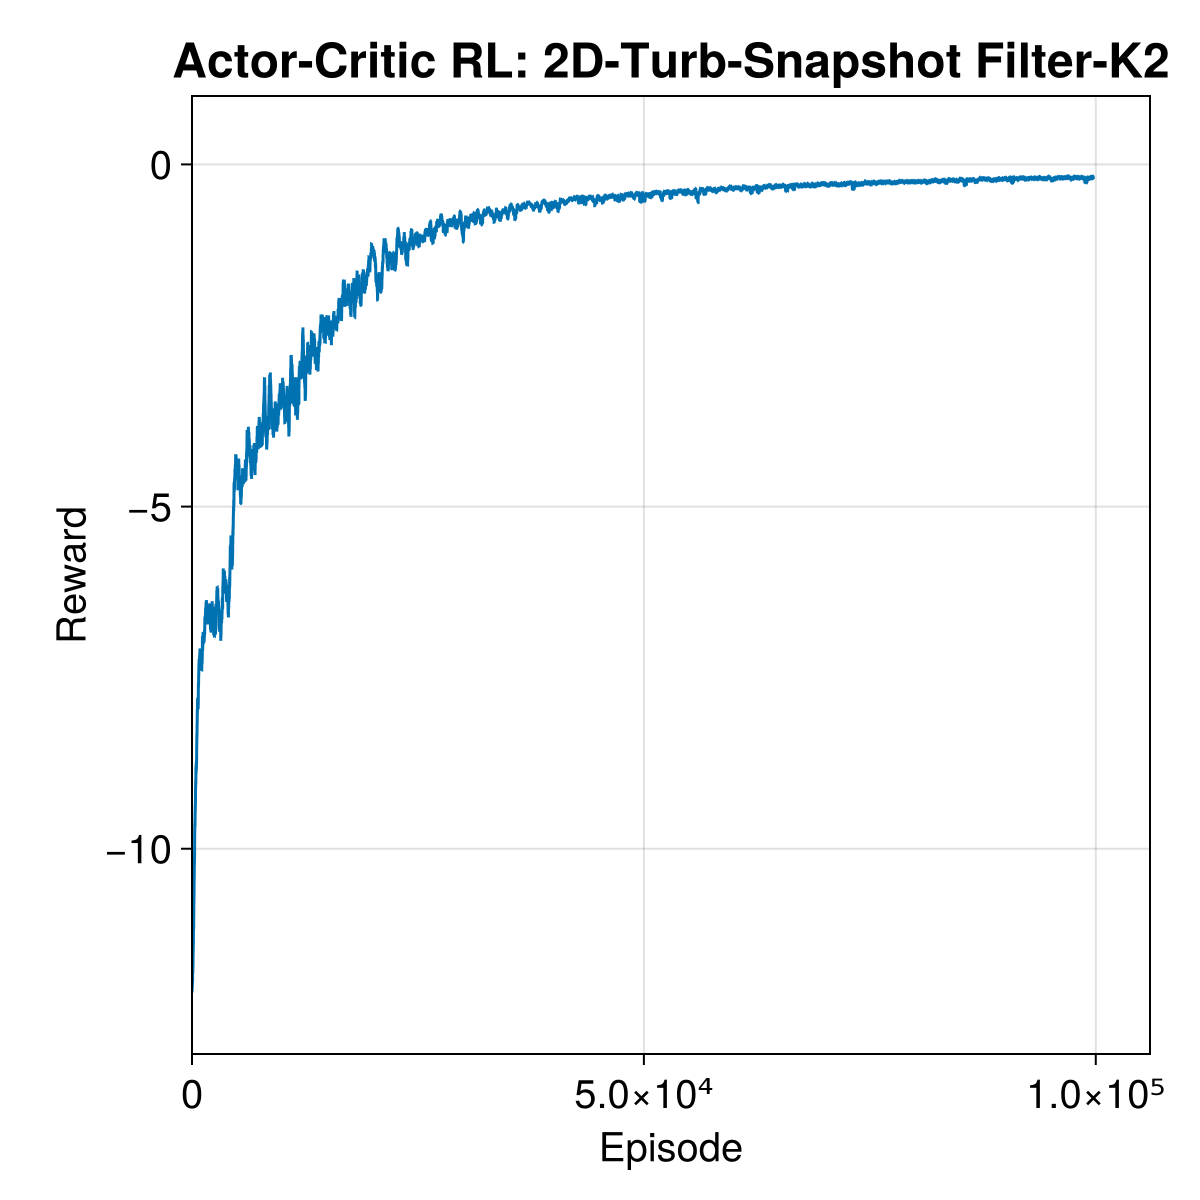

In [5]:
# Learning Progress: Reward vs. Episode Number
using CairoMakie

moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

fig = Figure(size = (600, 600))

ax = Axis(fig[1, 1],
    title = "Actor-Critic RL: 2D-Turb-Snapshot Filter-K2", titlesize=24,
    xlabel = "Episode", xlabelsize=20, xticklabelsize=20,
    ylabel = "Reward", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, 1.06*n_train), (-13, 1))
)

lines!(ax, moving_average(r_tracks,250))

save("2d-turb-snapshot-filter-k2 + reward.pdf", fig)
fig

### Evaluation of Learned Policy

In [6]:
x_tracks = []
y_tracks = []
θ_tracks = []
r_tracks = []

success_RL = ones(n_episodes)

for i in 1:n_episodes
    x_points = []
    y_points = []
    θ_points = []
    r_points = []

    x_now, y_now = start_point()
    step = 0

    while (is_terminal(x_now, y_now)==false)&&(step*Δt<T_max)        
        sx_now, sy_now = get_tile(x_now, y_now)
        θ_now = choose_greedy_action(sx_now,sy_now)

        push!(x_points, x_now)
        push!(y_points, y_now)
        push!(θ_points, θ_now)
        
        x_next, y_next = next_state(x_now, y_now, θ_now)
        step+=1
        
        reward = -Δt + w_reward*(sqrt((xB-x_now)^2+(yB-y_now)^2)/Va - sqrt((xB-x_next)^2+(yB-y_next)^2)/Va)
        
        if (x_next<=0)||(y_next<=0)||(x_next>=L)||(y_next>=L)
            reward=reward-2*T_max
            success_RL[i]=0
        elseif step*Δt>=T_max
            success_RL[i]=0
        end
        
        push!(r_points, reward)
        
        x_now, y_now = x_next, y_next 
    end
    
    # end of episode
    if is_terminal(x_now, y_now)==true
        push!(x_points, x_now)
        push!(y_points, y_now)
    end

    push!(x_tracks, x_points)
    push!(y_tracks, y_points)
    push!(θ_tracks, θ_points)
    push!(r_tracks, sum(r_points))
    
end

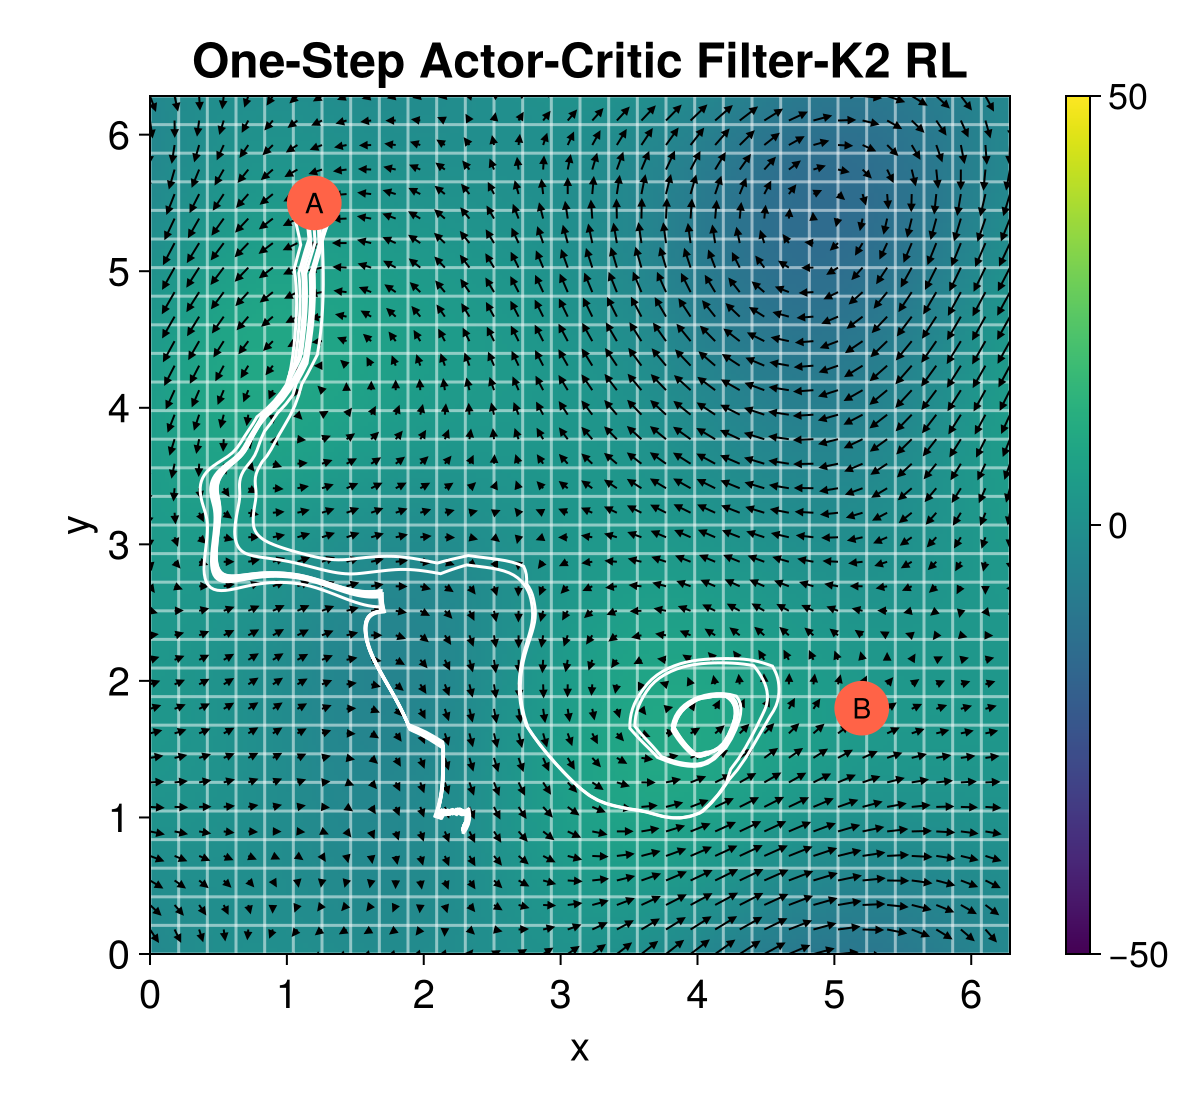

In [7]:
using CairoMakie

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = [vort_filt(x,y) for x in xs, y in ys]

xs2 = LinRange(0, L, 36)
ys2 = LinRange(0, L, 36)
us2 = [velX_filt(x,y) for x in xs2, y in ys2]
vs2 = [velY_filt(x,y) for x in xs2, y in ys2]

fig = Figure(size = (600, 550))

ax = Axis(fig[1, 1],
    title = "One-Step Actor-Critic Filter-K2 RL", titlesize=24,
    xlabel = "x", xlabelsize=20, xticklabelsize=20,
    ylabel = "y", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, L), (0,L)),
)

hm = heatmap!(ax, xs, ys, zs, colormap = :viridis, alpha=1.0, colorrange=(-50, 50))
Colorbar(fig[:, end+1], hm, ticklabelsize=18)

hlines!(ax, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
vlines!(ax, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows!(ax, xs2, ys2, us2, vs2, arrowsize = 6, lengthscale = 0.02,)

for i in 1:10
    lines!(ax, x_tracks[i], y_tracks[i], color=:white)
end

poly!(ax, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center))

poly!(ax, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center))

save("2d-turb-snapshot-filter-k2 + tracks.pdf", fig)
fig

Fail Probabitity = 1.0
Average Reward = -5.4782635622539155


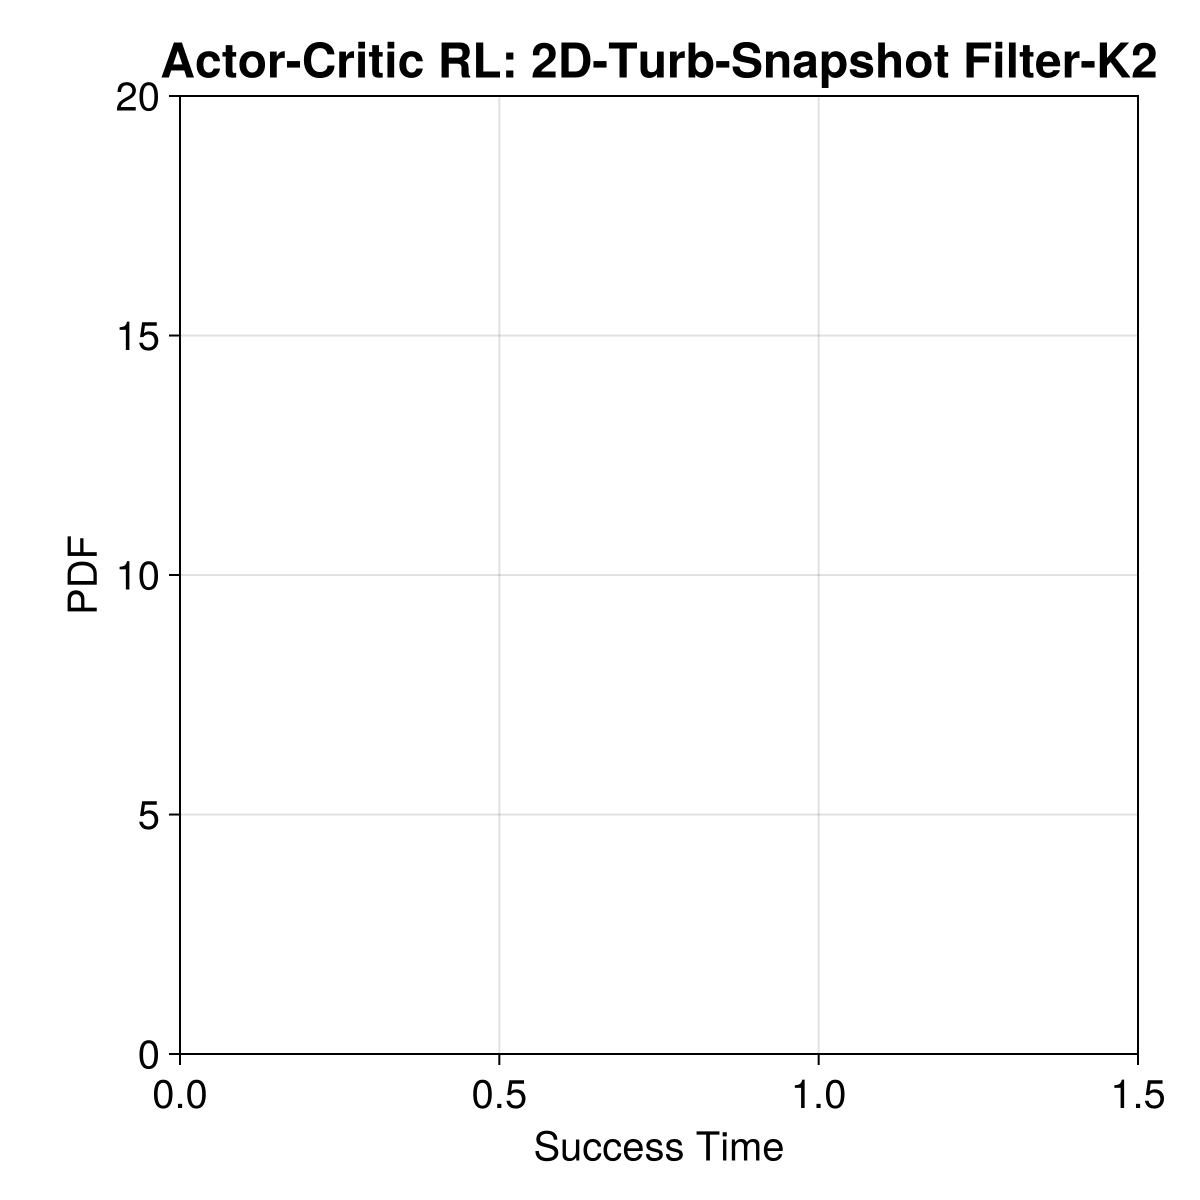

In [9]:
times_RL = zeros(Int(sum(success_RL)))
count_RL = 0

for i in 1:n_episodes
    if success_RL[i]==1
        count_RL+=1
        times_RL[count_RL] = length(x_tracks[i])*Δt
    end
end
    
println("Fail Probabitity = ", 1-sum(success_RL)/n_episodes)
println("Average Reward = ", sum(r_tracks)/n_episodes)

fig = Figure(size = (600, 600))

ax = Axis(fig[1, 1],
    title = "Actor-Critic RL: 2D-Turb-Snapshot Filter-K2", titlesize=24,
    xlabel = "Success Time", xlabelsize=20, xticklabelsize=20,
    ylabel = "PDF", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, 1.5), (0,20)),
)

hist!(ax, times_RL, normalization = :pdf, bins=0:0.05:1.5, strokewidth = 1, strokecolor = :black)

save("2d-turb-snapshot-filter-k2 + success times.pdf", fig)
fig